<img src="https://assets.avtocod.ru/storage/images/articles/stoimost-avto.jpg" alt="car price prediction" style="width:70%;"/>

# Car price prediction education competition using LightAutoML

Official LightAutoML github repository is [here](https://github.com/sberbank-ai-lab/LightAutoML). 

## 0. Prerequisites

### 0.0. install LightAutoML

In [96]:
#pip install -U lightautoml

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: `TabularAutoML` preset for AutoML model creation and Task class to setup what kind of ML problem we solve (binary/multiclass classification or regression)

In [3]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

### 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [4]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 1200 # equal to 20 minutes
TARGET_NAME = 'final_price'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [5]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [6]:
INPUT_DIR = '/home/mike/Documents/Coding/Data/Predict car price/'

In [7]:
train_data = pd.read_csv(INPUT_DIR + 'train_data.csv')
print(train_data.shape)
train_data.head()

(35000, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


In [8]:
test_data = pd.read_csv(INPUT_DIR + 'test_data.csv')
print(test_data.shape)
test_data.head()

(10697, 14)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
0,35000,TOYOTA,Prius,Hatchback,323733,2012,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale
1,35001,HYUNDAI,Elantra,Sedan,112000,2013,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale
2,35002,LEXUS,NX 300,Jeep,16920,2018,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale
3,35003,LEXUS,CT 200h,Hatchback,302742,2012,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale
4,35004,TOYOTA,RAV 4,Jeep,1800,2002,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale


In [9]:
submission = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
print(submission.shape)
submission.head()

(10697, 2)


,row_ID,final_price
0,35000,0
1,35001,0
2,35002,0
3,35003,0
4,35004,0


### 0.5. Data Review

In [10]:
my_data = train_data.copy()

In [121]:
#check out the data types
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    34999 non-null  object 
 2   vehicle_model           34993 non-null  object 
 3   vehicle_category        34999 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    34999 non-null  object 
 7   doors_cnt               34255 non-null  object 
 8   wheels                  34999 non-null  object 
 9   vehicle_color           34599 non-null  object 
 10  vehicle_interior_color  28282 non-null  object 
 11  car_vin                 11488 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

In [122]:
#check the duplicates

duplicates = my_data[my_data.duplicated()]
print('Duplicates number: {}'.format(duplicates.shape[0]))

Duplicates number: 0


vehicle_manufacturer          1
vehicle_model                 7
vehicle_category              1
vehicle_gearbox_type          1
doors_cnt                   745
wheels                        1
vehicle_color               401
vehicle_interior_color     6718
car_vin                   23512
dtype: int64

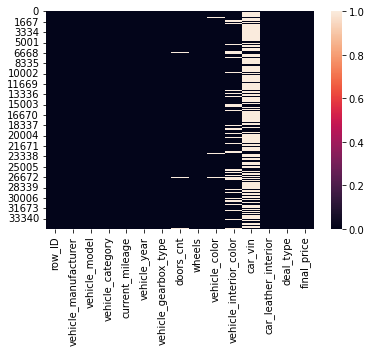

In [123]:
# check the nulls or missing values

sns.heatmap(my_data.isnull())

null_data = my_data.isnull().sum()
display(null_data[null_data > 0])

# we will remove the column 'car_vin' and fill the rest nulls with the most common values

### To decide what to do with the rows, let's see some other stats

In [133]:
#check out the number of unique and the most frequent values
my_data.describe(include=['int64', 'object', 'float64'])

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
count,35000.000000,34999,34993,34999,3.500000e+04,35000.000000,34999,34255,34999,34599,28282,11488,35000.000000,35000,3.500000e+04
unique,NaN,68,2224,11,NaN,NaN,4,3,2,16,11,4288,NaN,2,NaN
top,NaN,TOYOTA,Prius,Sedan,NaN,NaN,Automatic,4/5,Left wheel,Black,Black,4T1BD1FK7EU114553,NaN,For Sale,NaN
freq,NaN,6768,2350,15483,NaN,NaN,24290,32446,32207,9053,21083,42,NaN,34372,NaN
mean,17499.500000,NaN,NaN,NaN,1.969224e+06,2010.651743,NaN,NaN,NaN,NaN,NaN,NaN,0.715486,NaN,6.014077e+03
std,10103.774047,NaN,NaN,NaN,5.682401e+07,12.247792,NaN,NaN,NaN,NaN,NaN,NaN,0.451189,NaN,7.341517e+04
min,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000e+00
25%,8749.750000,NaN,NaN,NaN,7.145400e+04,2008.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,1.350000e+03
50%,17499.500000,NaN,NaN,NaN,1.290000e+05,2012.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,3.900000e+03
75%,26249.250000,NaN,NaN,NaN,1.900000e+05,2014.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,7.000000e+03


In [109]:
# see the manufacturers
my_data['vehicle_manufacturer'].value_counts()

# we will put most of them in several categories

TOYOTA           2144
HYUNDAI          1860
MERCEDES-BENZ    1222
FORD              726
LEXUS             559
                 ... 
TATA                1
HAVAL               1
BENTLEY             1
CHERY               1
SEAT                1
Name: vehicle_manufacturer, Length: 61, dtype: int64

In [110]:
# see the models
my_data['vehicle_model'].value_counts()

Prius              742
Camry              549
Sonata             499
Tucson             382
Elantra            368
                  ... 
X-Trail X-trail      1
Focus se             1
Golf 6               1
Astra F              1
Sequoia              1
Name: vehicle_model, Length: 1168, dtype: int64

In [111]:
# see the car types
my_data['vehicle_category'].value_counts()

# we will merge some categories

Sedan          4736
Jeep           3222
Hatchback      1597
Minivan         346
Coupe           291
Universal       170
Microbus        153
Goods wagon     129
Cabriolet        28
Pickup           20
Limousine         4
Name: vehicle_category, dtype: int64

In [112]:
# see gearbox types
my_data['vehicle_gearbox_type'].value_counts()

# we will merge some types

Automatic    7379
Tiptronic    1776
Manual       1111
Variator      430
Name: vehicle_gearbox_type, dtype: int64

### Let's check the outliers

In [113]:
#see the stats of the current mileage

fig = px.histogram(
    data_frame=my_data,
    x='current_mileage',
    title='Current Mileage Distribution',
    histnorm='percent',
    width=500,
    marginal='box',
)
fig.show()

# we will remove the outliers

In [12]:
#see the stats of the vehicle year

mask = my_data[my_data['vehicle_year'] > 0]

fig = px.histogram(
    data_frame=mask,
    x='vehicle_year',
    title='Vehicle Year Distribution',
    histnorm='percent',
    width=500,
    marginal='box',
)
fig.show()

# we will group the cars older than 25 y.o.

In [26]:
#see the stats of the final price

mask = my_data[(my_data['final_price'] > 100) & (my_data['final_price'] <100000)]

fig = px.histogram(
    data_frame=mask,
    x='final_price',
    title='Vehicle final price Distribution',
    histnorm='percent',
    width=500,
    marginal='box',
)
fig.show()

# we will group the cars older than 25 y.o.

### 0.6. Feature engineering

In [115]:
def create_expert_feats(data):
    
    # reduce the number of vehicle manufacturers
    # we will leave the top 7 manufacturers and put the rest of them into 
    # four categories: Luxury, Premium, Average, Russian
    def vehicle_manufacturer_update(manufacturer):
        Luxury = ['BENTLEY', 'LAMBORGHINI', 'FERRARI', 'MASERATI', 'CADILLAC', 
                  'JAGUAR', 'LINCOLN'
                  ]
        Premium = ['HUMMER', 'BUICK', 'ROVER', 'INFINITI', 'PORSCHE', 'LAND ROVER', 
                   'DODGE', 'AUDI', 'ALFA ROMEO', 'GMC', 'ROVER', 'TESLA', 
                   'CHRYSLER', 'JEEP', 'CHEVROLET'
                   ]
        Average = ['SEAT', 'CHERY', 'HAVAL', 'TATA', 'MERCURY', 'სხვა', 'SATURN', 
                   'ISUZU', 'DAIHATSU', 'SCION', 'CITROEN', 'VOLVO', 'PEUGEOT', 
                   'ACURA', 'SKODA', 'RENAULT', 'MINI', 'SUZUKI', 'DAEWOO', 'FIAT', 
                   'MAZDA', 'SSANGYONG', 'KIA', 'MITSUBISHI', 'SUBARU', 'OPEL', 
                   'NISSAN', 'HONDA'
                   ]
        Russian = ['ZAZ', 'MOSKVICH', 'GAZ', 'UAZ', 'VAZ']

        if manufacturer in Luxury:
            return 'Luxury'
        elif manufacturer in Premium:
            return 'Premium'
        elif manufacturer in Average:
            return 'Average'
        elif manufacturer in Russian:
            return 'Russian'
        else:
            return manufacturer
    
    data['vehicle_manufacturer'] = data['vehicle_manufacturer'].apply(vehicle_manufacturer_update)
    
    
    # let's merge the least common vehicle categories
    def vehicle_category_update(category):
        if (category == 'Goods wagon') or (category == 'Pickup'):
            return 'Hatchback'
        elif (category == 'Universal') or (category == 'Microbus'):
            return 'Minivan'
        elif category == 'Cabriolet':
            return 'Sedan'
        else:
            return category
    
    data['vehicle_category'] = data['vehicle_category'].apply(vehicle_category_update)
    
    
    # Remove the outdrops in the mileage
    data['current_mileage'] = data['current_mileage'].apply(lambda x: 300000 if x > 300000 else x)
    
    
    # Set up a new parameter - vehicle age
    data['age'] = 2022 - data['vehicle_year'] 
    
    
    # Fill the nulls in vehicle gearbox type with the most common option
    # Also, re-defin Variator and Tiptronic as Automatic
    # Convert this column into a binary parameter
    def vehicle_gearbox_type_update(type):
        if type == 'Manual':
            return 0
        else:
            return 1
    
    data['vehicle_gearbox_type'] = data['vehicle_gearbox_type'].apply(vehicle_gearbox_type_update)
    
    
    # Fill the nulls in some columns with the most common option
    values = {
    'doors_cnt': '4/5',
    'wheels': 'Left wheel',
    'vehicle_color': 'Black',
    'vehicle_interior_color': 'Black'
    }
    
    data = data.fillna(values)
    
    
    # Convert the column 'wheels' into a binary parameter
    data['wheels'] = data['wheels'].apply(lambda x: 1 if x == 'Left wheel' else 0)
    
    
    # Convert the column 'deal_type' into a binary parameter
    data['deal_type'] = data['deal_type'].apply(lambda x: 1 if x == 'For Sale' else 0)
    
    
    # remove unneeded columns including 'wheels' because of its multicollinearity with the age
    data.drop(['vehicle_year', 'car_vin', 'row_ID', 'wheels'], axis=1, inplace=True)
    
    return data